# GEM5 ARM

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum

### vars

In [2]:
#gem5Path = '/home/anton/Master/tools/gem5/gem5-Arm/' 
#build = 'build/X86/gem5.opt'
gem5Path = '/home/fft_vec/gem5/'
build = 'build/ARM/gem5.opt'

gem5 = gem5Path + build

baseDir = './bench/'  + build.replace('.', '-').replace('/','-') + '/'

In [3]:
config = gem5Path + 'configs/example/se.py'

In [4]:
defultOption = "--cpu-type=TimingSimpleCPU --cpu-clock=2GHz --l1d_size=64kB --l1i_size=16kB --caches"

In [5]:
darknet = './darknet'
yolo = 'bench_yolo'
#vgg = 'todo' 
#darknet19 = 'bench_darknet19'
#test = ""

In [6]:
armCompileOptions = 'CC=aarch64-none-linux-gnu-gcc CPP=aarch64-none-linux-gnu-g++' 

In [7]:
class Program(Enum):
    BASELINE = 0
    NNPACK_FT8 = 1
    NO_PREDICT = 2
    NO_PREDICT_NPP = 3
    NNPACK_GEMM = 4
    NNPACK_FT16 = 5
    NNPACK_WT = 6

## utils

In [8]:
def make(program):
    
    values = ""
    
    match program:
        case Program.BASELINE: values = 'NNPACK=0'        
        case Program.NNPACK_FT8:   values = 'NNPACK=1 FT8=1'
        case Program.NNPACK_FT16:   values = 'NNPACK=1 FT16=1'
        case Program.NNPACK_WT:   values = 'NNPACK=1 WT=1'
        case Program.NNPACK_GEMM: values = 'NNPACK=1 GEMM=1' 
        case Program.NO_PREDICT_NPP: values = 'NNPACK=1 NO_PREDICT=1 FT8=1' 
        case Program.NO_PREDICT: values = 'NNPACK=0 NO_PREDICT=1' 
        
            
    os.system('make clean; make'+ ' ' + values + ' ' + armCompileOptions) 

In [9]:
def optionsToSubDir(benchmark, program, tag):
    
    if benchmark == '':
        benchmark = 'NAN' 
    
    programStr = 'NAN'
    
    match program:
        case Program.BASELINE: programStr = 'BASELINE'        
        case Program.NNPACK_FT8:   programStr = 'FT8'
        case Program.NNPACK_FT16:   programStr = 'FT16'
        case Program.NNPACK_WT:   programStr = 'WT'
        case Program.NNPACK_GEMM: programStr = 'GEMM' 
        case Program.NO_PREDICT_NPP: programStr = 'NO_PREDICT_NPP' 
        case Program.NO_PREDICT: programStr = 'NO_PREDICT' 

    path = '/'.join([benchmark,programStr,tag]) + '/'
    
    return path

In [10]:
def cyclesToSetup(program, benchmark_to_run,tag):
    make(program);
    out = bench(benchmark_to_run,'--l2_size=64MB --l2cache',program, tag)
    print(out)
    data = readData([out])
    print(data)
    return ([out], data)

def cyclesToSetup_baseline(benchmark_to_run):
    return cyclesToSetup(Program.NO_PREDICT,benchmark_to_run,'setup_baseline')

def cyclesToSetup_npp(benchmark_to_run):
    return cyclesToSetup(Program.NO_PREDICT_NPP,benchmark_to_run,'setup_npp')

In [11]:
def readData(Dirs):
    data = []
    names = ['simTicks']
    for Dir in Dirs: 
    
        result = []
    
        file = Dir+'stats.txt'
        print("reading data from file: ",file,"\n ")
        with open(file, 'r') as fp:
            lines = fp.readlines()
            for row in lines:
                for name in names:
                    if row.find(name) == 0:
                        value = int(row.split()[1])
                        result.append((name,value))
    
        data.append(result)                
        
    return data

In [12]:
def bench(benchmark, options, program, tag):

    outDir =  baseDir + optionsToSubDir(benchmark, program, tag)
    out = '--outdir='+ outDir
    
    binary = '-c ' + '"'+ darknet  + '"' + ' --options ' + '"' + benchmark + '"'
    
    cmd = ' '.join([gem5,out,config,defultOption,'--output=stdout.txt  --errout=stderr.txt',options,binary])
   
    print(cmd + '\n\n')
    
    os.system(cmd)
    
    return(outDir)

In [13]:
def run_benchmark(benchmark, options, nnpack, tag):
    out = bench(benchmark, options, nnpack, tag)
    return(out)

In [14]:
def benchOptions(benchmark, optionsList, program, tags):
    
    n = len(optionsList)
    
    out = [None] * n
    
    for i in range(n):
        out[i] = run_benchmark(benchmark, optionsList[i], program, tags[i])
        
    return(out)

In [15]:
def benchOptionsMatrix(benchmark, options1, options2, nnpack, tags1, tags2): #to bench vector and l2 chace
    options =[opt1 + ' ' + opt2 for opt1 in options1 for opt2 in options2]
    tags = [tag1 + '_' + tag2 for tag1 in tags1 for tag2 in tags2]
    
    out = benchOptions(benchmark, options, nnpack, tags) 
    return(out)

### util graphs

In [16]:
def plotChaceVsCycle(chaces,data, setupcost):
    cycles = [ i[0][1]-setupcost[0][1] for i in data]
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    print(cycles)
    print(chaces)
    ax.bar(chaces,cycles)
    plt.show()
    
    

In [17]:
def runandPlot(program,benchmark_to_run ,options, tags, setup_cost ):
    make(program)
    out = benchOptions(benchmark_to_run,options,program,tags)
    print(out)
    data = readData(out)
    print(data)
    plotChaceVsCycle(tags[::-1],data[::-1], setup_cost[1][0])
    return(out,data)
    

In [18]:
def readandplot(dirs,x_line,setupticks):
    y_line = readData(dirs)
    plotChaceVsCycle(x_line,y_line, setupticks[1][0])
    

# X86 YOLO and L2 chace

In [19]:
#yolo = ''

In [20]:
setupticks = cyclesToSetup_baseline(yolo)
setupticks

rm -rf ./obj/gemm.o ./obj/utils.o ./obj/cuda.o ./obj/deconvolutional_layer.o ./obj/convolutional_layer.o ./obj/list.o ./obj/image.o ./obj/activations.o ./obj/im2col.o ./obj/col2im.o ./obj/blas.o ./obj/crop_layer.o ./obj/dropout_layer.o ./obj/maxpool_layer.o ./obj/softmax_layer.o ./obj/data.o ./obj/matrix.o ./obj/network.o ./obj/connected_layer.o ./obj/cost_layer.o ./obj/parser.o ./obj/option_list.o ./obj/detection_layer.o ./obj/route_layer.o ./obj/upsample_layer.o ./obj/box.o ./obj/normalization_layer.o ./obj/avgpool_layer.o ./obj/layer.o ./obj/local_layer.o ./obj/shortcut_layer.o ./obj/logistic_layer.o ./obj/activation_layer.o ./obj/rnn_layer.o ./obj/gru_layer.o ./obj/crnn_layer.o ./obj/demo.o ./obj/batchnorm_layer.o ./obj/region_layer.o ./obj/reorg_layer.o ./obj/tree.o ./obj/lstm_layer.o ./obj/l2norm_layer.o ./obj/yolo_layer.o ./obj/iseg_layer.o ./obj/image_opencv.o libdarknet.so libdarknet.a darknet ./obj/captcha.o ./obj/lsd.o ./obj/super.o ./obj/art.o ./obj/tag.o ./obj/cifar.o ./ob

gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -c ./examples/lsd.c -o obj/lsd.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -c ./examples/super.c -o obj/super.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -c ./examples/art.c -o obj/art.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -c ./examples/tag.c -o obj/tag.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -c ./examples/cifar.c -o obj/cifar.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -c ./examples/go.c -o obj/go.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -c ./examples/rnn.c -o obj/rnn.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-e

./examples/detector.c: In function ‘test_detector’:
./examples/detector.c:585:24: warning: ‘return’ with no value, in function returning non-void [-Wreturn-type]
  585 |             if(!input) return;
      |                        ^~~~~~
./examples/detector.c:562:7: note: declared here
  562 | float test_detector(char *datacfg, char *cfgfile, char *weightfile, char *filename, float thresh, float hier_thresh, char *outfile, int fullscreen)
      |       ^~~~~~~~~~~~~


gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -c ./examples/nightmare.c -o obj/nightmare.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -c ./examples/instance-segmenter.c -o obj/instance-segmenter.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -c ./examples/darknet.c -o obj/darknet.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -c ./examples/test.c -o obj/test.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast obj/captcha.o obj/lsd.o obj/super.o obj/art.o obj/tag.o obj/cifar.o obj/go.o obj/rnn.o obj/segmenter.o obj/regressor.o obj/classifier.o obj/coco.o obj/yolo.o obj/detector.o obj/nightmare.o obj/instance-segmenter.o obj/darknet.o obj/test.o libdarknet.a -o darknet -lm -pthread libdarknet.a
/home/anton/Master/tools/gem5/gem5-Ar

warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: failed to generate dot output from ./bench/build-X86-gem5-opt/NAN/NO_PREDICT/setup_baseline/config.dot
build/X86/mem/dram_interface.cc:690: warn: DRAM device capacity (8192 Mbytes) does not match the address range assigned (512 Mbytes)


Global frequency set at 1000000000000 ticks per second


build/X86/base/remote_gdb.cc:416: warn: Sockets disabled, not accepting gdb connections
build/X86/sim/simulate.cc:192: info: Entering event queue @ 0.  Starting simulation...
build/X86/sim/syscall_emul.cc:74: warn: ignoring syscall set_robust_list(...)
build/X86/sim/syscall_emul.cc:74: warn: ignoring syscall rseq(...)
build/X86/sim/mem_state.cc:443: info: Increasing stack size by one page.
build/X86/sim/syscall_emul.cc:74: warn: ignoring syscall mprotect(...)
build/X86/sim/mem_state.cc:443: info: Increasing stack size by one page.


gem5 Simulator System.  https://www.gem5.org
gem5 is copyrighted software; use the --copyright option for details.

gem5 version 22.1.0.0
gem5 compiled Jan 24 2023 19:03:31
gem5 started Feb 12 2023 16:58:12
gem5 executing on anton-mint, pid 14525
command line: /home/anton/Master/tools/gem5/gem5-Arm/build/X86/gem5.opt --outdir=./bench/build-X86-gem5-opt/NAN/NO_PREDICT/setup_baseline/ /home/anton/Master/tools/gem5/gem5-Arm/configs/example/se.py --cpu-type=TimingSimpleCPU --cpu-clock=2GHz --l1d_size=64kB --l1i_size=16kB --caches --output=stdout.txt --errout=stderr.txt --l2_size=64MB --l2cache -c ./darknet --options ''

info: Standard input is not a terminal, disabling listeners.
**** REAL SIMULATION ****
Exiting @ tick 87820500 because exiting with last active thread context
./bench/build-X86-gem5-opt/NAN/NO_PREDICT/setup_baseline/
reading data from file:  ./bench/build-X86-gem5-opt/NAN/NO_PREDICT/setup_baseline/stats.txt 
 
[[('simTicks', 87820500)]]


(['./bench/build-X86-gem5-opt/NAN/NO_PREDICT/setup_baseline/'],
 [[('simTicks', 87820500)]])

In [21]:
setupnppticks_npp = cyclesToSetup_npp(yolo)
setupnppticks_npp

rm -rf ./obj/gemm.o ./obj/utils.o ./obj/cuda.o ./obj/deconvolutional_layer.o ./obj/convolutional_layer.o ./obj/list.o ./obj/image.o ./obj/activations.o ./obj/im2col.o ./obj/col2im.o ./obj/blas.o ./obj/crop_layer.o ./obj/dropout_layer.o ./obj/maxpool_layer.o ./obj/softmax_layer.o ./obj/data.o ./obj/matrix.o ./obj/network.o ./obj/connected_layer.o ./obj/cost_layer.o ./obj/parser.o ./obj/option_list.o ./obj/detection_layer.o ./obj/route_layer.o ./obj/upsample_layer.o ./obj/box.o ./obj/normalization_layer.o ./obj/avgpool_layer.o ./obj/layer.o ./obj/local_layer.o ./obj/shortcut_layer.o ./obj/logistic_layer.o ./obj/activation_layer.o ./obj/rnn_layer.o ./obj/gru_layer.o ./obj/crnn_layer.o ./obj/demo.o ./obj/batchnorm_layer.o ./obj/region_layer.o ./obj/reorg_layer.o ./obj/tree.o ./obj/lstm_layer.o ./obj/l2norm_layer.o ./obj/yolo_layer.o ./obj/iseg_layer.o ./obj/image_opencv.o libdarknet.so libdarknet.a darknet ./obj/captcha.o ./obj/lsd.o ./obj/super.o ./obj/art.o ./obj/tag.o ./obj/cifar.o ./ob

./src/convolutional_layer.c: In function ‘forward_convolutional_layer_nnp’:
./src/convolutional_layer.c:549:9: warning: unused variable ‘k’ [-Wunused-variable]
  549 |     int k = l.size*l.size*l.c/l.groups;
      |         ^


gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./src/list.c -o obj/list.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./src/image.c -o obj/image.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./src/activations.c -o obj/activations.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./src/im2col.c -o obj/im2col.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./src/col2im.c -o obj/col2im.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./src/blas.c -o obj/blas.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./src/crop_layer.c -o obj/crop_layer.o
gcc -

gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./examples/classifier.c -o obj/classifier.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./examples/coco.c -o obj/coco.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./examples/yolo.c -o obj/yolo.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./examples/detector.c -o obj/detector.o


./examples/detector.c: In function ‘test_detector’:
./examples/detector.c:585:24: warning: ‘return’ with no value, in function returning non-void [-Wreturn-type]
  585 |             if(!input) return;
      |                        ^~~~~~
./examples/detector.c:562:7: note: declared here
  562 | float test_detector(char *datacfg, char *cfgfile, char *weightfile, char *filename, float thresh, float hier_thresh, char *outfile, int fullscreen)
      |       ^~~~~~~~~~~~~


gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./examples/nightmare.c -o obj/nightmare.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./examples/instance-segmenter.c -o obj/instance-segmenter.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./examples/darknet.c -o obj/darknet.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./examples/test.c -o obj/test.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK obj/captcha.o obj/lsd.o obj/super.o obj/art.o obj/tag.o obj/cifar.o obj/go.o obj/rnn.o obj/segmenter.o obj/regressor.o obj/classifier.o obj/coco.o obj/yolo.o obj/detector.o obj/nightmare.o obj/instance-segmenter.o obj/darknet.o obj/test.o libdarknet.a -o darknet -lm -pthread -l:li

warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: failed to generate dot output from ./bench/build-X86-gem5-opt/NAN/NO_PREDICT_NPP/setup_npp/config.dot
build/X86/mem/dram_interface.cc:690: warn: DRAM device capacity (8192 Mbytes) does not match the address range assigned (512 Mbytes)


Global frequency set at 1000000000000 ticks per second


build/X86/base/remote_gdb.cc:416: warn: Sockets disabled, not accepting gdb connections
build/X86/sim/simulate.cc:192: info: Entering event queue @ 0.  Starting simulation...
build/X86/sim/syscall_emul.cc:74: warn: ignoring syscall set_robust_list(...)
build/X86/sim/syscall_emul.cc:74: warn: ignoring syscall rseq(...)
build/X86/sim/mem_state.cc:443: info: Increasing stack size by one page.
build/X86/sim/syscall_emul.cc:74: warn: ignoring syscall mprotect(...)
build/X86/arch/x86/cpuid.cc:180: warn: x86 cpuid family 0x0000: unimplemented function 2
build/X86/sim/mem_state.cc:443: info: Increasing stack size by one page.


gem5 Simulator System.  https://www.gem5.org
gem5 is copyrighted software; use the --copyright option for details.

gem5 version 22.1.0.0
gem5 compiled Jan 24 2023 19:03:31
gem5 started Feb 12 2023 16:58:29
gem5 executing on anton-mint, pid 14729
command line: /home/anton/Master/tools/gem5/gem5-Arm/build/X86/gem5.opt --outdir=./bench/build-X86-gem5-opt/NAN/NO_PREDICT_NPP/setup_npp/ /home/anton/Master/tools/gem5/gem5-Arm/configs/example/se.py --cpu-type=TimingSimpleCPU --cpu-clock=2GHz --l1d_size=64kB --l1i_size=16kB --caches --output=stdout.txt --errout=stderr.txt --l2_size=64MB --l2cache -c ./darknet --options ''

info: Standard input is not a terminal, disabling listeners.
**** REAL SIMULATION ****
Exiting @ tick 177698500 because exiting with last active thread context
./bench/build-X86-gem5-opt/NAN/NO_PREDICT_NPP/setup_npp/
reading data from file:  ./bench/build-X86-gem5-opt/NAN/NO_PREDICT_NPP/setup_npp/stats.txt 
 
[[('simTicks', 177698500)]]


(['./bench/build-X86-gem5-opt/NAN/NO_PREDICT_NPP/setup_npp/'],
 [[('simTicks', 177698500)]])

In [22]:
chaceSizes = ['256MB','64MB','8MB','1MB']
chaceOptions = ['--l2_size=' + size + ' --l2cache' for size in chaceSizes]
chaceOptions

['--l2_size=256MB --l2cache',
 '--l2_size=64MB --l2cache',
 '--l2_size=8MB --l2cache',
 '--l2_size=1MB --l2cache']

## baseline

rm -rf ./obj/gemm.o ./obj/utils.o ./obj/cuda.o ./obj/deconvolutional_layer.o ./obj/convolutional_layer.o ./obj/list.o ./obj/image.o ./obj/activations.o ./obj/im2col.o ./obj/col2im.o ./obj/blas.o ./obj/crop_layer.o ./obj/dropout_layer.o ./obj/maxpool_layer.o ./obj/softmax_layer.o ./obj/data.o ./obj/matrix.o ./obj/network.o ./obj/connected_layer.o ./obj/cost_layer.o ./obj/parser.o ./obj/option_list.o ./obj/detection_layer.o ./obj/route_layer.o ./obj/upsample_layer.o ./obj/box.o ./obj/normalization_layer.o ./obj/avgpool_layer.o ./obj/layer.o ./obj/local_layer.o ./obj/shortcut_layer.o ./obj/logistic_layer.o ./obj/activation_layer.o ./obj/rnn_layer.o ./obj/gru_layer.o ./obj/crnn_layer.o ./obj/demo.o ./obj/batchnorm_layer.o ./obj/region_layer.o ./obj/reorg_layer.o ./obj/tree.o ./obj/lstm_layer.o ./obj/l2norm_layer.o ./obj/yolo_layer.o ./obj/iseg_layer.o ./obj/image_opencv.o libdarknet.so libdarknet.a darknet ./obj/captcha.o ./obj/lsd.o ./obj/super.o ./obj/art.o ./obj/tag.o ./obj/cifar.o ./ob

gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -c ./examples/captcha.c -o obj/captcha.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -c ./examples/lsd.c -o obj/lsd.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -c ./examples/super.c -o obj/super.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -c ./examples/art.c -o obj/art.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -c ./examples/tag.c -o obj/tag.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -c ./examples/cifar.c -o obj/cifar.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -c ./examples/go.c -o obj/go.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -

./examples/detector.c: In function ‘test_detector’:
./examples/detector.c:585:24: warning: ‘return’ with no value, in function returning non-void [-Wreturn-type]
  585 |             if(!input) return;
      |                        ^~~~~~
./examples/detector.c:562:7: note: declared here
  562 | float test_detector(char *datacfg, char *cfgfile, char *weightfile, char *filename, float thresh, float hier_thresh, char *outfile, int fullscreen)
      |       ^~~~~~~~~~~~~


gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -c ./examples/nightmare.c -o obj/nightmare.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -c ./examples/instance-segmenter.c -o obj/instance-segmenter.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -c ./examples/darknet.c -o obj/darknet.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -c ./examples/test.c -o obj/test.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast obj/captcha.o obj/lsd.o obj/super.o obj/art.o obj/tag.o obj/cifar.o obj/go.o obj/rnn.o obj/segmenter.o obj/regressor.o obj/classifier.o obj/coco.o obj/yolo.o obj/detector.o obj/nightmare.o obj/instance-segmenter.o obj/darknet.o obj/test.o libdarknet.a -o darknet -lm -pthread libdarknet.a
/home/anton/Master/tools/gem5/gem5-Ar

warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: failed to generate dot output from ./bench/build-X86-gem5-opt/NAN/BASELINE/256MB/config.dot
build/X86/mem/dram_interface.cc:690: warn: DRAM device capacity (8192 Mbytes) does not match the address range assigned (512 Mbytes)


Global frequency set at 1000000000000 ticks per second


build/X86/base/remote_gdb.cc:416: warn: Sockets disabled, not accepting gdb connections
build/X86/sim/simulate.cc:192: info: Entering event queue @ 0.  Starting simulation...
build/X86/sim/syscall_emul.cc:74: warn: ignoring syscall set_robust_list(...)
build/X86/sim/syscall_emul.cc:74: warn: ignoring syscall rseq(...)
build/X86/sim/mem_state.cc:443: info: Increasing stack size by one page.
build/X86/sim/syscall_emul.cc:74: warn: ignoring syscall mprotect(...)
build/X86/sim/mem_state.cc:443: info: Increasing stack size by one page.


gem5 Simulator System.  https://www.gem5.org
gem5 is copyrighted software; use the --copyright option for details.

gem5 version 22.1.0.0
gem5 compiled Jan 24 2023 19:03:31
gem5 started Feb 12 2023 16:58:47
gem5 executing on anton-mint, pid 14934
command line: /home/anton/Master/tools/gem5/gem5-Arm/build/X86/gem5.opt --outdir=./bench/build-X86-gem5-opt/NAN/BASELINE/256MB/ /home/anton/Master/tools/gem5/gem5-Arm/configs/example/se.py --cpu-type=TimingSimpleCPU --cpu-clock=2GHz --l1d_size=64kB --l1i_size=16kB --caches --output=stdout.txt --errout=stderr.txt --l2_size=256MB --l2cache -c ./darknet --options ''

info: Standard input is not a terminal, disabling listeners.
**** REAL SIMULATION ****
Exiting @ tick 87820500 because exiting with last active thread context
/home/anton/Master/tools/gem5/gem5-Arm/build/X86/gem5.opt --outdir=./bench/build-X86-gem5-opt/NAN/BASELINE/64MB/ /home/anton/Master/tools/gem5/gem5-Arm/configs/example/se.py --cpu-type=TimingSimpleCPU --cpu-clock=2GHz --l1d_siz

warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: failed to generate dot output from ./bench/build-X86-gem5-opt/NAN/BASELINE/64MB/config.dot
build/X86/mem/dram_interface.cc:690: warn: DRAM device capacity (8192 Mbytes) does not match the address range assigned (512 Mbytes)


Global frequency set at 1000000000000 ticks per second


build/X86/base/remote_gdb.cc:416: warn: Sockets disabled, not accepting gdb connections
build/X86/sim/simulate.cc:192: info: Entering event queue @ 0.  Starting simulation...
build/X86/sim/syscall_emul.cc:74: warn: ignoring syscall set_robust_list(...)
build/X86/sim/syscall_emul.cc:74: warn: ignoring syscall rseq(...)
build/X86/sim/mem_state.cc:443: info: Increasing stack size by one page.
build/X86/sim/syscall_emul.cc:74: warn: ignoring syscall mprotect(...)
build/X86/sim/mem_state.cc:443: info: Increasing stack size by one page.


gem5 Simulator System.  https://www.gem5.org
gem5 is copyrighted software; use the --copyright option for details.

gem5 version 22.1.0.0
gem5 compiled Jan 24 2023 19:03:31
gem5 started Feb 12 2023 16:58:48
gem5 executing on anton-mint, pid 14937
command line: /home/anton/Master/tools/gem5/gem5-Arm/build/X86/gem5.opt --outdir=./bench/build-X86-gem5-opt/NAN/BASELINE/64MB/ /home/anton/Master/tools/gem5/gem5-Arm/configs/example/se.py --cpu-type=TimingSimpleCPU --cpu-clock=2GHz --l1d_size=64kB --l1i_size=16kB --caches --output=stdout.txt --errout=stderr.txt --l2_size=64MB --l2cache -c ./darknet --options ''

info: Standard input is not a terminal, disabling listeners.
**** REAL SIMULATION ****
Exiting @ tick 87820500 because exiting with last active thread context
/home/anton/Master/tools/gem5/gem5-Arm/build/X86/gem5.opt --outdir=./bench/build-X86-gem5-opt/NAN/BASELINE/8MB/ /home/anton/Master/tools/gem5/gem5-Arm/configs/example/se.py --cpu-type=TimingSimpleCPU --cpu-clock=2GHz --l1d_size=6

warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: failed to generate dot output from ./bench/build-X86-gem5-opt/NAN/BASELINE/8MB/config.dot
build/X86/mem/dram_interface.cc:690: warn: DRAM device capacity (8192 Mbytes) does not match the address range assigned (512 Mbytes)


Global frequency set at 1000000000000 ticks per second


build/X86/base/remote_gdb.cc:416: warn: Sockets disabled, not accepting gdb connections
build/X86/sim/simulate.cc:192: info: Entering event queue @ 0.  Starting simulation...
build/X86/sim/syscall_emul.cc:74: warn: ignoring syscall set_robust_list(...)
build/X86/sim/syscall_emul.cc:74: warn: ignoring syscall rseq(...)
build/X86/sim/mem_state.cc:443: info: Increasing stack size by one page.
build/X86/sim/syscall_emul.cc:74: warn: ignoring syscall mprotect(...)
build/X86/sim/mem_state.cc:443: info: Increasing stack size by one page.


gem5 Simulator System.  https://www.gem5.org
gem5 is copyrighted software; use the --copyright option for details.

gem5 version 22.1.0.0
gem5 compiled Jan 24 2023 19:03:31
gem5 started Feb 12 2023 16:58:49
gem5 executing on anton-mint, pid 14940
command line: /home/anton/Master/tools/gem5/gem5-Arm/build/X86/gem5.opt --outdir=./bench/build-X86-gem5-opt/NAN/BASELINE/8MB/ /home/anton/Master/tools/gem5/gem5-Arm/configs/example/se.py --cpu-type=TimingSimpleCPU --cpu-clock=2GHz --l1d_size=64kB --l1i_size=16kB --caches --output=stdout.txt --errout=stderr.txt --l2_size=8MB --l2cache -c ./darknet --options ''

info: Standard input is not a terminal, disabling listeners.
**** REAL SIMULATION ****
Exiting @ tick 87820500 because exiting with last active thread context
/home/anton/Master/tools/gem5/gem5-Arm/build/X86/gem5.opt --outdir=./bench/build-X86-gem5-opt/NAN/BASELINE/1MB/ /home/anton/Master/tools/gem5/gem5-Arm/configs/example/se.py --cpu-type=TimingSimpleCPU --cpu-clock=2GHz --l1d_size=64k

warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: failed to generate dot output from ./bench/build-X86-gem5-opt/NAN/BASELINE/1MB/config.dot
build/X86/mem/dram_interface.cc:690: warn: DRAM device capacity (8192 Mbytes) does not match the address range assigned (512 Mbytes)
build/X86/base/remote_gdb.cc:416: warn: Sockets disabled, not accepting gdb connections


Global frequency set at 1000000000000 ticks per second
gem5 Simulator System.  https://www.gem5.org
gem5 is copyrighted software; use the --copyright option for details.

gem5 version 22.1.0.0
gem5 compiled Jan 24 2023 19:03:31
gem5 started Feb 12 2023 16:58:50
gem5 executing on anton-mint, pid 14943
command line: /home/anton/Master/tools/gem5/gem5-Arm/build/X86/gem5.opt --outdir=./bench/build-X86-gem5-opt/NAN/BASELINE/1MB/ /home/anton/Master/tools/gem5/gem5-Arm/configs/example/se.py --cpu-type=TimingSimpleCPU --cpu-clock=2GHz --l1d_size=64kB --l1i_size=16kB --caches --output=stdout.txt --errout=stderr.txt --l2_size=1MB --l2cache -c ./darknet --options ''

info: Standard input is not a terminal, disabling listeners.
**** REAL SIMULATION ****
Exiting @ tick 87820500 because exiting with last active thread context
['./bench/build-X86-gem5-opt/NAN/BASELINE/256MB/', './bench/build-X86-gem5-opt/NAN/BASELINE/64MB/', './bench/build-X86-gem5-opt/NAN/BASELINE/8MB/', './bench/build-X86-gem5-opt/

build/X86/sim/simulate.cc:192: info: Entering event queue @ 0.  Starting simulation...
build/X86/sim/syscall_emul.cc:74: warn: ignoring syscall set_robust_list(...)
build/X86/sim/syscall_emul.cc:74: warn: ignoring syscall rseq(...)
build/X86/sim/mem_state.cc:443: info: Increasing stack size by one page.
build/X86/sim/syscall_emul.cc:74: warn: ignoring syscall mprotect(...)
build/X86/sim/mem_state.cc:443: info: Increasing stack size by one page.


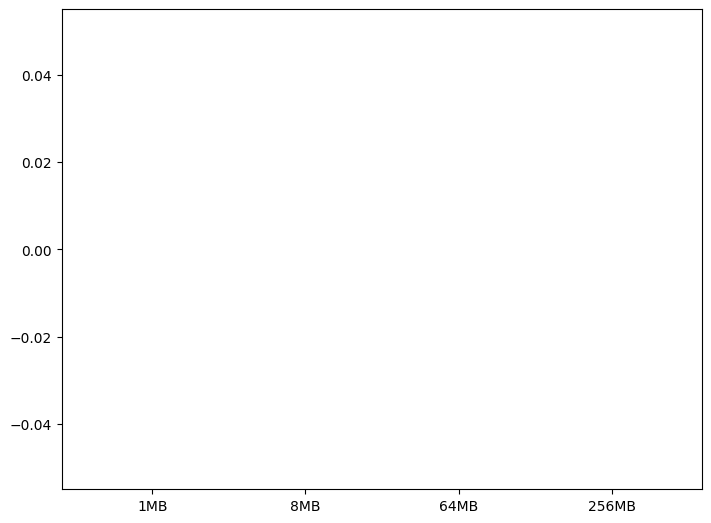

In [23]:
baslineResult = runandPlot(Program.BASELINE,yolo ,chaceOptions, chaceSizes, setupticks)

reading data from file:  ./bench/build-X86-gem5-opt/NAN/BASELINE/256MB/stats.txt 
 
reading data from file:  ./bench/build-X86-gem5-opt/NAN/BASELINE/64MB/stats.txt 
 
reading data from file:  ./bench/build-X86-gem5-opt/NAN/BASELINE/8MB/stats.txt 
 
reading data from file:  ./bench/build-X86-gem5-opt/NAN/BASELINE/1MB/stats.txt 
 
[0, 0, 0, 0]
['256MB', '64MB', '8MB', '1MB']


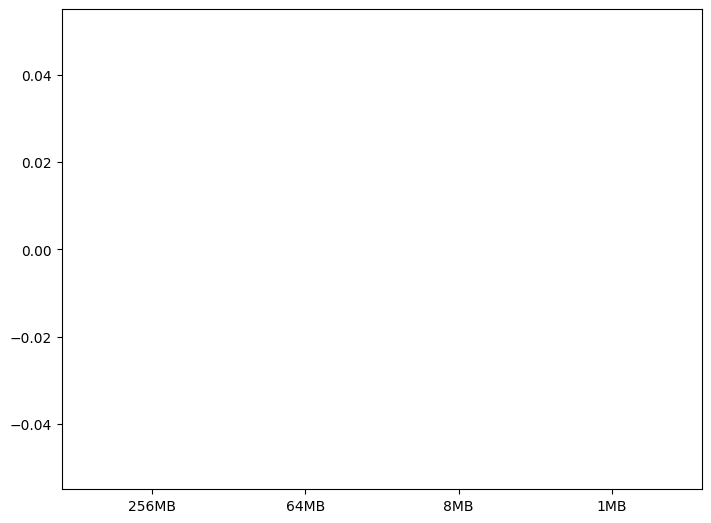

In [24]:
readandplot(baslineResult[0],chaceSizes,setupticks)

# FT8

rm -rf ./obj/gemm.o ./obj/utils.o ./obj/cuda.o ./obj/deconvolutional_layer.o ./obj/convolutional_layer.o ./obj/list.o ./obj/image.o ./obj/activations.o ./obj/im2col.o ./obj/col2im.o ./obj/blas.o ./obj/crop_layer.o ./obj/dropout_layer.o ./obj/maxpool_layer.o ./obj/softmax_layer.o ./obj/data.o ./obj/matrix.o ./obj/network.o ./obj/connected_layer.o ./obj/cost_layer.o ./obj/parser.o ./obj/option_list.o ./obj/detection_layer.o ./obj/route_layer.o ./obj/upsample_layer.o ./obj/box.o ./obj/normalization_layer.o ./obj/avgpool_layer.o ./obj/layer.o ./obj/local_layer.o ./obj/shortcut_layer.o ./obj/logistic_layer.o ./obj/activation_layer.o ./obj/rnn_layer.o ./obj/gru_layer.o ./obj/crnn_layer.o ./obj/demo.o ./obj/batchnorm_layer.o ./obj/region_layer.o ./obj/reorg_layer.o ./obj/tree.o ./obj/lstm_layer.o ./obj/l2norm_layer.o ./obj/yolo_layer.o ./obj/iseg_layer.o ./obj/image_opencv.o libdarknet.so libdarknet.a darknet ./obj/captcha.o ./obj/lsd.o ./obj/super.o ./obj/art.o ./obj/tag.o ./obj/cifar.o ./ob

./src/convolutional_layer.c: In function ‘forward_convolutional_layer_nnp’:
./src/convolutional_layer.c:549:9: warning: unused variable ‘k’ [-Wunused-variable]
  549 |     int k = l.size*l.size*l.c/l.groups;
      |         ^


gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./src/list.c -o obj/list.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./src/image.c -o obj/image.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./src/activations.c -o obj/activations.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./src/im2col.c -o obj/im2col.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./src/col2im.c -o obj/col2im.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./src/blas.c -o obj/blas.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./src/crop_layer.c -o obj/crop_layer.o
gcc -

gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./examples/classifier.c -o obj/classifier.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./examples/coco.c -o obj/coco.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./examples/yolo.c -o obj/yolo.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./examples/detector.c -o obj/detector.o


./examples/detector.c: In function ‘test_detector’:
./examples/detector.c:585:24: warning: ‘return’ with no value, in function returning non-void [-Wreturn-type]
  585 |             if(!input) return;
      |                        ^~~~~~
./examples/detector.c:562:7: note: declared here
  562 | float test_detector(char *datacfg, char *cfgfile, char *weightfile, char *filename, float thresh, float hier_thresh, char *outfile, int fullscreen)
      |       ^~~~~~~~~~~~~


gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./examples/nightmare.c -o obj/nightmare.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./examples/instance-segmenter.c -o obj/instance-segmenter.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./examples/darknet.c -o obj/darknet.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./examples/test.c -o obj/test.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK obj/captcha.o obj/lsd.o obj/super.o obj/art.o obj/tag.o obj/cifar.o obj/go.o obj/rnn.o obj/segmenter.o obj/regressor.o obj/classifier.o obj/coco.o obj/yolo.o obj/detector.o obj/nightmare.o obj/instance-segmenter.o obj/darknet.o obj/test.o libdarknet.a -o darknet -lm -pthread -l:li

warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: failed to generate dot output from ./bench/build-X86-gem5-opt/NAN/FT8/256MB/config.dot
build/X86/mem/dram_interface.cc:690: warn: DRAM device capacity (8192 Mbytes) does not match the address range assigned (512 Mbytes)


Global frequency set at 1000000000000 ticks per second


build/X86/base/remote_gdb.cc:416: warn: Sockets disabled, not accepting gdb connections
build/X86/sim/simulate.cc:192: info: Entering event queue @ 0.  Starting simulation...
build/X86/sim/syscall_emul.cc:74: warn: ignoring syscall set_robust_list(...)
build/X86/sim/syscall_emul.cc:74: warn: ignoring syscall rseq(...)
build/X86/sim/mem_state.cc:443: info: Increasing stack size by one page.
build/X86/sim/syscall_emul.cc:74: warn: ignoring syscall mprotect(...)
build/X86/arch/x86/cpuid.cc:180: warn: x86 cpuid family 0x0000: unimplemented function 2
build/X86/sim/mem_state.cc:443: info: Increasing stack size by one page.


gem5 Simulator System.  https://www.gem5.org
gem5 is copyrighted software; use the --copyright option for details.

gem5 version 22.1.0.0
gem5 compiled Jan 24 2023 19:03:31
gem5 started Feb 12 2023 16:59:07
gem5 executing on anton-mint, pid 15148
command line: /home/anton/Master/tools/gem5/gem5-Arm/build/X86/gem5.opt --outdir=./bench/build-X86-gem5-opt/NAN/FT8/256MB/ /home/anton/Master/tools/gem5/gem5-Arm/configs/example/se.py --cpu-type=TimingSimpleCPU --cpu-clock=2GHz --l1d_size=64kB --l1i_size=16kB --caches --output=stdout.txt --errout=stderr.txt --l2_size=256MB --l2cache -c ./darknet --options ''

info: Standard input is not a terminal, disabling listeners.
**** REAL SIMULATION ****
Exiting @ tick 177698500 because exiting with last active thread context
/home/anton/Master/tools/gem5/gem5-Arm/build/X86/gem5.opt --outdir=./bench/build-X86-gem5-opt/NAN/FT8/64MB/ /home/anton/Master/tools/gem5/gem5-Arm/configs/example/se.py --cpu-type=TimingSimpleCPU --cpu-clock=2GHz --l1d_size=64kB --

warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.


Global frequency set at 1000000000000 ticks per second


warn: failed to generate dot output from ./bench/build-X86-gem5-opt/NAN/FT8/64MB/config.dot
build/X86/mem/dram_interface.cc:690: warn: DRAM device capacity (8192 Mbytes) does not match the address range assigned (512 Mbytes)
build/X86/base/remote_gdb.cc:416: warn: Sockets disabled, not accepting gdb connections
build/X86/sim/simulate.cc:192: info: Entering event queue @ 0.  Starting simulation...
build/X86/sim/syscall_emul.cc:74: warn: ignoring syscall set_robust_list(...)
build/X86/sim/syscall_emul.cc:74: warn: ignoring syscall rseq(...)
build/X86/sim/mem_state.cc:443: info: Increasing stack size by one page.


gem5 Simulator System.  https://www.gem5.org
gem5 is copyrighted software; use the --copyright option for details.

gem5 version 22.1.0.0
gem5 compiled Jan 24 2023 19:03:31
gem5 started Feb 12 2023 16:59:09
gem5 executing on anton-mint, pid 15151
command line: /home/anton/Master/tools/gem5/gem5-Arm/build/X86/gem5.opt --outdir=./bench/build-X86-gem5-opt/NAN/FT8/64MB/ /home/anton/Master/tools/gem5/gem5-Arm/configs/example/se.py --cpu-type=TimingSimpleCPU --cpu-clock=2GHz --l1d_size=64kB --l1i_size=16kB --caches --output=stdout.txt --errout=stderr.txt --l2_size=64MB --l2cache -c ./darknet --options ''

info: Standard input is not a terminal, disabling listeners.
**** REAL SIMULATION ****


build/X86/sim/syscall_emul.cc:74: warn: ignoring syscall mprotect(...)
build/X86/arch/x86/cpuid.cc:180: warn: x86 cpuid family 0x0000: unimplemented function 2
build/X86/sim/mem_state.cc:443: info: Increasing stack size by one page.


Exiting @ tick 177698500 because exiting with last active thread context
/home/anton/Master/tools/gem5/gem5-Arm/build/X86/gem5.opt --outdir=./bench/build-X86-gem5-opt/NAN/FT8/8MB/ /home/anton/Master/tools/gem5/gem5-Arm/configs/example/se.py --cpu-type=TimingSimpleCPU --cpu-clock=2GHz --l1d_size=64kB --l1i_size=16kB --caches --output=stdout.txt  --errout=stderr.txt --l2_size=8MB --l2cache -c "./darknet" --options ""




warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.


Global frequency set at 1000000000000 ticks per second


warn: failed to generate dot output from ./bench/build-X86-gem5-opt/NAN/FT8/8MB/config.dot
build/X86/mem/dram_interface.cc:690: warn: DRAM device capacity (8192 Mbytes) does not match the address range assigned (512 Mbytes)
build/X86/base/remote_gdb.cc:416: warn: Sockets disabled, not accepting gdb connections
build/X86/sim/simulate.cc:192: info: Entering event queue @ 0.  Starting simulation...
build/X86/sim/syscall_emul.cc:74: warn: ignoring syscall set_robust_list(...)
build/X86/sim/syscall_emul.cc:74: warn: ignoring syscall rseq(...)
build/X86/sim/mem_state.cc:443: info: Increasing stack size by one page.
build/X86/sim/syscall_emul.cc:74: warn: ignoring syscall mprotect(...)
build/X86/arch/x86/cpuid.cc:180: warn: x86 cpuid family 0x0000: unimplemented function 2
build/X86/sim/mem_state.cc:443: info: Increasing stack size by one page.


gem5 Simulator System.  https://www.gem5.org
gem5 is copyrighted software; use the --copyright option for details.

gem5 version 22.1.0.0
gem5 compiled Jan 24 2023 19:03:31
gem5 started Feb 12 2023 16:59:10
gem5 executing on anton-mint, pid 15154
command line: /home/anton/Master/tools/gem5/gem5-Arm/build/X86/gem5.opt --outdir=./bench/build-X86-gem5-opt/NAN/FT8/8MB/ /home/anton/Master/tools/gem5/gem5-Arm/configs/example/se.py --cpu-type=TimingSimpleCPU --cpu-clock=2GHz --l1d_size=64kB --l1i_size=16kB --caches --output=stdout.txt --errout=stderr.txt --l2_size=8MB --l2cache -c ./darknet --options ''

info: Standard input is not a terminal, disabling listeners.
**** REAL SIMULATION ****
Exiting @ tick 177698500 because exiting with last active thread context
/home/anton/Master/tools/gem5/gem5-Arm/build/X86/gem5.opt --outdir=./bench/build-X86-gem5-opt/NAN/FT8/1MB/ /home/anton/Master/tools/gem5/gem5-Arm/configs/example/se.py --cpu-type=TimingSimpleCPU --cpu-clock=2GHz --l1d_size=64kB --l1i_s

warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.


Global frequency set at 1000000000000 ticks per second


warn: failed to generate dot output from ./bench/build-X86-gem5-opt/NAN/FT8/1MB/config.dot
build/X86/mem/dram_interface.cc:690: warn: DRAM device capacity (8192 Mbytes) does not match the address range assigned (512 Mbytes)
build/X86/base/remote_gdb.cc:416: warn: Sockets disabled, not accepting gdb connections
build/X86/sim/simulate.cc:192: info: Entering event queue @ 0.  Starting simulation...
build/X86/sim/syscall_emul.cc:74: warn: ignoring syscall set_robust_list(...)
build/X86/sim/syscall_emul.cc:74: warn: ignoring syscall rseq(...)
build/X86/sim/mem_state.cc:443: info: Increasing stack size by one page.
build/X86/sim/syscall_emul.cc:74: warn: ignoring syscall mprotect(...)
build/X86/arch/x86/cpuid.cc:180: warn: x86 cpuid family 0x0000: unimplemented function 2
build/X86/sim/mem_state.cc:443: info: Increasing stack size by one page.


gem5 Simulator System.  https://www.gem5.org
gem5 is copyrighted software; use the --copyright option for details.

gem5 version 22.1.0.0
gem5 compiled Jan 24 2023 19:03:31
gem5 started Feb 12 2023 16:59:11
gem5 executing on anton-mint, pid 15157
command line: /home/anton/Master/tools/gem5/gem5-Arm/build/X86/gem5.opt --outdir=./bench/build-X86-gem5-opt/NAN/FT8/1MB/ /home/anton/Master/tools/gem5/gem5-Arm/configs/example/se.py --cpu-type=TimingSimpleCPU --cpu-clock=2GHz --l1d_size=64kB --l1i_size=16kB --caches --output=stdout.txt --errout=stderr.txt --l2_size=1MB --l2cache -c ./darknet --options ''

info: Standard input is not a terminal, disabling listeners.
**** REAL SIMULATION ****
Exiting @ tick 177698500 because exiting with last active thread context
['./bench/build-X86-gem5-opt/NAN/FT8/256MB/', './bench/build-X86-gem5-opt/NAN/FT8/64MB/', './bench/build-X86-gem5-opt/NAN/FT8/8MB/', './bench/build-X86-gem5-opt/NAN/FT8/1MB/']
reading data from file:  ./bench/build-X86-gem5-opt/NAN/FT8

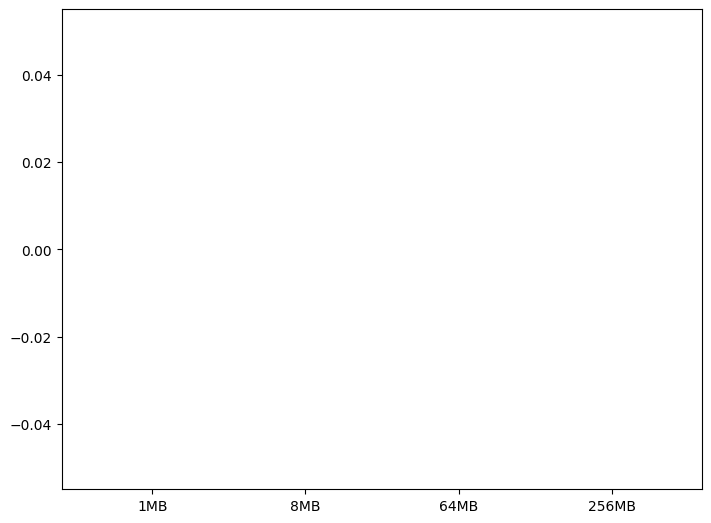

In [25]:
ft8Result = runandPlot(Program.NNPACK_FT8,yolo ,chaceOptions, chaceSizes, setupnppticks_npp)

reading data from file:  ./bench/build-X86-gem5-opt/NAN/FT8/256MB/stats.txt 
 
reading data from file:  ./bench/build-X86-gem5-opt/NAN/FT8/64MB/stats.txt 
 
reading data from file:  ./bench/build-X86-gem5-opt/NAN/FT8/8MB/stats.txt 
 
reading data from file:  ./bench/build-X86-gem5-opt/NAN/FT8/1MB/stats.txt 
 
[0, 0, 0, 0]
['256MB', '64MB', '8MB', '1MB']


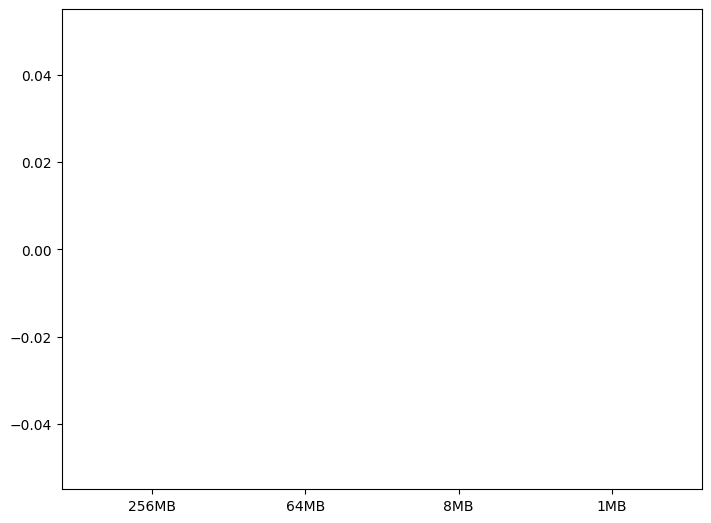

In [26]:
readandplot(ft8Result[0],chaceSizes,setupnppticks_npp)

# FT16

rm -rf ./obj/gemm.o ./obj/utils.o ./obj/cuda.o ./obj/deconvolutional_layer.o ./obj/convolutional_layer.o ./obj/list.o ./obj/image.o ./obj/activations.o ./obj/im2col.o ./obj/col2im.o ./obj/blas.o ./obj/crop_layer.o ./obj/dropout_layer.o ./obj/maxpool_layer.o ./obj/softmax_layer.o ./obj/data.o ./obj/matrix.o ./obj/network.o ./obj/connected_layer.o ./obj/cost_layer.o ./obj/parser.o ./obj/option_list.o ./obj/detection_layer.o ./obj/route_layer.o ./obj/upsample_layer.o ./obj/box.o ./obj/normalization_layer.o ./obj/avgpool_layer.o ./obj/layer.o ./obj/local_layer.o ./obj/shortcut_layer.o ./obj/logistic_layer.o ./obj/activation_layer.o ./obj/rnn_layer.o ./obj/gru_layer.o ./obj/crnn_layer.o ./obj/demo.o ./obj/batchnorm_layer.o ./obj/region_layer.o ./obj/reorg_layer.o ./obj/tree.o ./obj/lstm_layer.o ./obj/l2norm_layer.o ./obj/yolo_layer.o ./obj/iseg_layer.o ./obj/image_opencv.o libdarknet.so libdarknet.a darknet ./obj/captcha.o ./obj/lsd.o ./obj/super.o ./obj/art.o ./obj/tag.o ./obj/cifar.o ./ob

./src/convolutional_layer.c: In function ‘forward_convolutional_layer_nnp’:
./src/convolutional_layer.c:549:9: warning: unused variable ‘k’ [-Wunused-variable]
  549 |     int k = l.size*l.size*l.c/l.groups;
      |         ^


gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./src/list.c -o obj/list.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./src/image.c -o obj/image.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./src/activations.c -o obj/activations.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./src/im2col.c -o obj/im2col.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./src/col2im.c -o obj/col2im.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./src/blas.c -o obj/blas.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./src/crop_layer.c -o obj/crop_layer.o
gcc -

gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./examples/classifier.c -o obj/classifier.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./examples/coco.c -o obj/coco.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./examples/yolo.c -o obj/yolo.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./examples/detector.c -o obj/detector.o


./examples/detector.c: In function ‘test_detector’:
./examples/detector.c:585:24: warning: ‘return’ with no value, in function returning non-void [-Wreturn-type]
  585 |             if(!input) return;
      |                        ^~~~~~
./examples/detector.c:562:7: note: declared here
  562 | float test_detector(char *datacfg, char *cfgfile, char *weightfile, char *filename, float thresh, float hier_thresh, char *outfile, int fullscreen)
      |       ^~~~~~~~~~~~~


gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./examples/nightmare.c -o obj/nightmare.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./examples/instance-segmenter.c -o obj/instance-segmenter.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./examples/darknet.c -o obj/darknet.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./examples/test.c -o obj/test.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK obj/captcha.o obj/lsd.o obj/super.o obj/art.o obj/tag.o obj/cifar.o obj/go.o obj/rnn.o obj/segmenter.o obj/regressor.o obj/classifier.o obj/coco.o obj/yolo.o obj/detector.o obj/nightmare.o obj/instance-segmenter.o obj/darknet.o obj/test.o libdarknet.a -o darknet -lm -pthread -l:li

warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: failed to generate dot output from ./bench/build-X86-gem5-opt/NAN/FT16/256MB/config.dot
build/X86/mem/dram_interface.cc:690: warn: DRAM device capacity (8192 Mbytes) does not match the address range assigned (512 Mbytes)


Global frequency set at 1000000000000 ticks per second


build/X86/base/remote_gdb.cc:416: warn: Sockets disabled, not accepting gdb connections
build/X86/sim/simulate.cc:192: info: Entering event queue @ 0.  Starting simulation...
build/X86/sim/syscall_emul.cc:74: warn: ignoring syscall set_robust_list(...)
build/X86/sim/syscall_emul.cc:74: warn: ignoring syscall rseq(...)
build/X86/sim/mem_state.cc:443: info: Increasing stack size by one page.
build/X86/sim/syscall_emul.cc:74: warn: ignoring syscall mprotect(...)
build/X86/arch/x86/cpuid.cc:180: warn: x86 cpuid family 0x0000: unimplemented function 2
build/X86/sim/mem_state.cc:443: info: Increasing stack size by one page.


gem5 Simulator System.  https://www.gem5.org
gem5 is copyrighted software; use the --copyright option for details.

gem5 version 22.1.0.0
gem5 compiled Jan 24 2023 19:03:31
gem5 started Feb 12 2023 16:59:30
gem5 executing on anton-mint, pid 15361
command line: /home/anton/Master/tools/gem5/gem5-Arm/build/X86/gem5.opt --outdir=./bench/build-X86-gem5-opt/NAN/FT16/256MB/ /home/anton/Master/tools/gem5/gem5-Arm/configs/example/se.py --cpu-type=TimingSimpleCPU --cpu-clock=2GHz --l1d_size=64kB --l1i_size=16kB --caches --output=stdout.txt --errout=stderr.txt --l2_size=256MB --l2cache -c ./darknet --options ''

info: Standard input is not a terminal, disabling listeners.
**** REAL SIMULATION ****
Exiting @ tick 177698500 because exiting with last active thread context
/home/anton/Master/tools/gem5/gem5-Arm/build/X86/gem5.opt --outdir=./bench/build-X86-gem5-opt/NAN/FT16/64MB/ /home/anton/Master/tools/gem5/gem5-Arm/configs/example/se.py --cpu-type=TimingSimpleCPU --cpu-clock=2GHz --l1d_size=64kB 

warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: failed to generate dot output from ./bench/build-X86-gem5-opt/NAN/FT16/64MB/config.dot
build/X86/mem/dram_interface.cc:690: warn: DRAM device capacity (8192 Mbytes) does not match the address range assigned (512 Mbytes)


Global frequency set at 1000000000000 ticks per second


build/X86/base/remote_gdb.cc:416: warn: Sockets disabled, not accepting gdb connections
build/X86/sim/simulate.cc:192: info: Entering event queue @ 0.  Starting simulation...
build/X86/sim/syscall_emul.cc:74: warn: ignoring syscall set_robust_list(...)
build/X86/sim/syscall_emul.cc:74: warn: ignoring syscall rseq(...)
build/X86/sim/mem_state.cc:443: info: Increasing stack size by one page.
build/X86/sim/syscall_emul.cc:74: warn: ignoring syscall mprotect(...)
build/X86/arch/x86/cpuid.cc:180: warn: x86 cpuid family 0x0000: unimplemented function 2
build/X86/sim/mem_state.cc:443: info: Increasing stack size by one page.


gem5 Simulator System.  https://www.gem5.org
gem5 is copyrighted software; use the --copyright option for details.

gem5 version 22.1.0.0
gem5 compiled Jan 24 2023 19:03:31
gem5 started Feb 12 2023 16:59:31
gem5 executing on anton-mint, pid 15364
command line: /home/anton/Master/tools/gem5/gem5-Arm/build/X86/gem5.opt --outdir=./bench/build-X86-gem5-opt/NAN/FT16/64MB/ /home/anton/Master/tools/gem5/gem5-Arm/configs/example/se.py --cpu-type=TimingSimpleCPU --cpu-clock=2GHz --l1d_size=64kB --l1i_size=16kB --caches --output=stdout.txt --errout=stderr.txt --l2_size=64MB --l2cache -c ./darknet --options ''

info: Standard input is not a terminal, disabling listeners.
**** REAL SIMULATION ****
Exiting @ tick 177698500 because exiting with last active thread context
/home/anton/Master/tools/gem5/gem5-Arm/build/X86/gem5.opt --outdir=./bench/build-X86-gem5-opt/NAN/FT16/8MB/ /home/anton/Master/tools/gem5/gem5-Arm/configs/example/se.py --cpu-type=TimingSimpleCPU --cpu-clock=2GHz --l1d_size=64kB --l

warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: failed to generate dot output from ./bench/build-X86-gem5-opt/NAN/FT16/8MB/config.dot
build/X86/mem/dram_interface.cc:690: warn: DRAM device capacity (8192 Mbytes) does not match the address range assigned (512 Mbytes)


Global frequency set at 1000000000000 ticks per second


build/X86/base/remote_gdb.cc:416: warn: Sockets disabled, not accepting gdb connections
build/X86/sim/simulate.cc:192: info: Entering event queue @ 0.  Starting simulation...
build/X86/sim/syscall_emul.cc:74: warn: ignoring syscall set_robust_list(...)
build/X86/sim/syscall_emul.cc:74: warn: ignoring syscall rseq(...)
build/X86/sim/mem_state.cc:443: info: Increasing stack size by one page.
build/X86/sim/syscall_emul.cc:74: warn: ignoring syscall mprotect(...)
build/X86/arch/x86/cpuid.cc:180: warn: x86 cpuid family 0x0000: unimplemented function 2
build/X86/sim/mem_state.cc:443: info: Increasing stack size by one page.


gem5 Simulator System.  https://www.gem5.org
gem5 is copyrighted software; use the --copyright option for details.

gem5 version 22.1.0.0
gem5 compiled Jan 24 2023 19:03:31
gem5 started Feb 12 2023 16:59:32
gem5 executing on anton-mint, pid 15367
command line: /home/anton/Master/tools/gem5/gem5-Arm/build/X86/gem5.opt --outdir=./bench/build-X86-gem5-opt/NAN/FT16/8MB/ /home/anton/Master/tools/gem5/gem5-Arm/configs/example/se.py --cpu-type=TimingSimpleCPU --cpu-clock=2GHz --l1d_size=64kB --l1i_size=16kB --caches --output=stdout.txt --errout=stderr.txt --l2_size=8MB --l2cache -c ./darknet --options ''

info: Standard input is not a terminal, disabling listeners.
**** REAL SIMULATION ****
Exiting @ tick 177698500 because exiting with last active thread context
/home/anton/Master/tools/gem5/gem5-Arm/build/X86/gem5.opt --outdir=./bench/build-X86-gem5-opt/NAN/FT16/1MB/ /home/anton/Master/tools/gem5/gem5-Arm/configs/example/se.py --cpu-type=TimingSimpleCPU --cpu-clock=2GHz --l1d_size=64kB --l1i

warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: failed to generate dot output from ./bench/build-X86-gem5-opt/NAN/FT16/1MB/config.dot
build/X86/mem/dram_interface.cc:690: warn: DRAM device capacity (8192 Mbytes) does not match the address range assigned (512 Mbytes)
build/X86/base/remote_gdb.cc:416: warn: Sockets disabled, not accepting gdb connections


Global frequency set at 1000000000000 ticks per second
gem5 Simulator System.  https://www.gem5.org
gem5 is copyrighted software; use the --copyright option for details.

gem5 version 22.1.0.0
gem5 compiled Jan 24 2023 19:03:31
gem5 started Feb 12 2023 16:59:33
gem5 executing on anton-mint, pid 15370
command line: /home/anton/Master/tools/gem5/gem5-Arm/build/X86/gem5.opt --outdir=./bench/build-X86-gem5-opt/NAN/FT16/1MB/ /home/anton/Master/tools/gem5/gem5-Arm/configs/example/se.py --cpu-type=TimingSimpleCPU --cpu-clock=2GHz --l1d_size=64kB --l1i_size=16kB --caches --output=stdout.txt --errout=stderr.txt --l2_size=1MB --l2cache -c ./darknet --options ''

info: Standard input is not a terminal, disabling listeners.
**** REAL SIMULATION ****


build/X86/sim/simulate.cc:192: info: Entering event queue @ 0.  Starting simulation...
build/X86/sim/syscall_emul.cc:74: warn: ignoring syscall set_robust_list(...)
build/X86/sim/syscall_emul.cc:74: warn: ignoring syscall rseq(...)
build/X86/sim/mem_state.cc:443: info: Increasing stack size by one page.
build/X86/sim/syscall_emul.cc:74: warn: ignoring syscall mprotect(...)
build/X86/arch/x86/cpuid.cc:180: warn: x86 cpuid family 0x0000: unimplemented function 2
build/X86/sim/mem_state.cc:443: info: Increasing stack size by one page.


Exiting @ tick 177698500 because exiting with last active thread context
['./bench/build-X86-gem5-opt/NAN/FT16/256MB/', './bench/build-X86-gem5-opt/NAN/FT16/64MB/', './bench/build-X86-gem5-opt/NAN/FT16/8MB/', './bench/build-X86-gem5-opt/NAN/FT16/1MB/']
reading data from file:  ./bench/build-X86-gem5-opt/NAN/FT16/256MB/stats.txt 
 
reading data from file:  ./bench/build-X86-gem5-opt/NAN/FT16/64MB/stats.txt 
 
reading data from file:  ./bench/build-X86-gem5-opt/NAN/FT16/8MB/stats.txt 
 
reading data from file:  ./bench/build-X86-gem5-opt/NAN/FT16/1MB/stats.txt 
 
[[('simTicks', 177698500)], [('simTicks', 177698500)], [('simTicks', 177698500)], [('simTicks', 177698500)]]
[0, 0, 0, 0]
['1MB', '8MB', '64MB', '256MB']


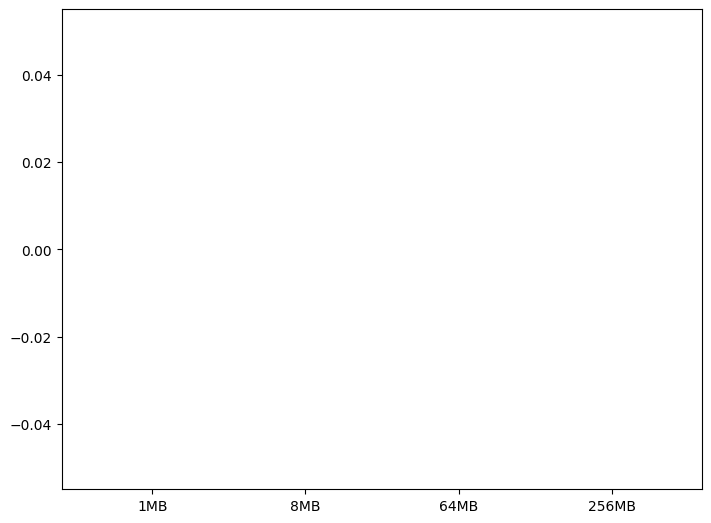

In [27]:
ft16Result = runandPlot(Program.NNPACK_FT16,yolo ,chaceOptions, chaceSizes, setupnppticks_npp)

reading data from file:  ./bench/build-X86-gem5-opt/NAN/FT16/256MB/stats.txt 
 
reading data from file:  ./bench/build-X86-gem5-opt/NAN/FT16/64MB/stats.txt 
 
reading data from file:  ./bench/build-X86-gem5-opt/NAN/FT16/8MB/stats.txt 
 
reading data from file:  ./bench/build-X86-gem5-opt/NAN/FT16/1MB/stats.txt 
 
[0, 0, 0, 0]
['256MB', '64MB', '8MB', '1MB']


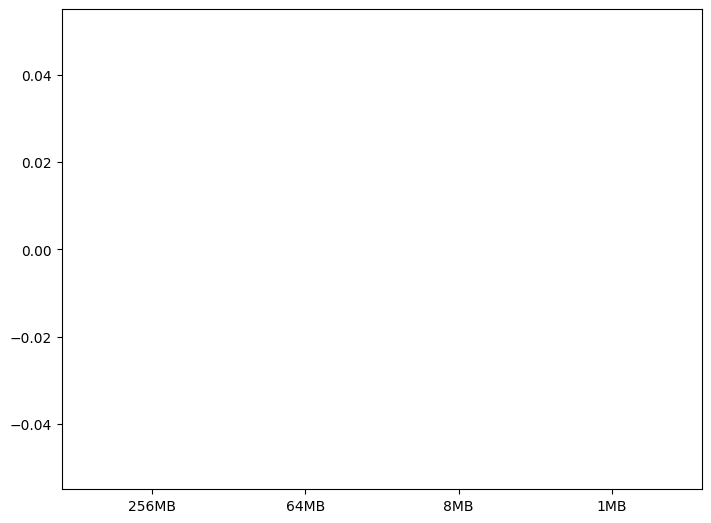

In [28]:
readandplot(ft16Result[0],chaceSizes,setupnppticks_npp)

# GEMM

rm -rf ./obj/gemm.o ./obj/utils.o ./obj/cuda.o ./obj/deconvolutional_layer.o ./obj/convolutional_layer.o ./obj/list.o ./obj/image.o ./obj/activations.o ./obj/im2col.o ./obj/col2im.o ./obj/blas.o ./obj/crop_layer.o ./obj/dropout_layer.o ./obj/maxpool_layer.o ./obj/softmax_layer.o ./obj/data.o ./obj/matrix.o ./obj/network.o ./obj/connected_layer.o ./obj/cost_layer.o ./obj/parser.o ./obj/option_list.o ./obj/detection_layer.o ./obj/route_layer.o ./obj/upsample_layer.o ./obj/box.o ./obj/normalization_layer.o ./obj/avgpool_layer.o ./obj/layer.o ./obj/local_layer.o ./obj/shortcut_layer.o ./obj/logistic_layer.o ./obj/activation_layer.o ./obj/rnn_layer.o ./obj/gru_layer.o ./obj/crnn_layer.o ./obj/demo.o ./obj/batchnorm_layer.o ./obj/region_layer.o ./obj/reorg_layer.o ./obj/tree.o ./obj/lstm_layer.o ./obj/l2norm_layer.o ./obj/yolo_layer.o ./obj/iseg_layer.o ./obj/image_opencv.o libdarknet.so libdarknet.a darknet ./obj/captcha.o ./obj/lsd.o ./obj/super.o ./obj/art.o ./obj/tag.o ./obj/cifar.o ./ob

./src/convolutional_layer.c: In function ‘forward_convolutional_layer_nnp’:
./src/convolutional_layer.c:549:9: warning: unused variable ‘k’ [-Wunused-variable]
  549 |     int k = l.size*l.size*l.c/l.groups;
      |         ^


gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./src/list.c -o obj/list.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./src/image.c -o obj/image.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./src/activations.c -o obj/activations.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./src/im2col.c -o obj/im2col.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./src/col2im.c -o obj/col2im.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./src/blas.c -o obj/blas.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./src/crop_layer.c -o obj/crop_layer.o
gcc -

gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./examples/classifier.c -o obj/classifier.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./examples/coco.c -o obj/coco.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./examples/yolo.c -o obj/yolo.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./examples/detector.c -o obj/detector.o


./examples/detector.c: In function ‘test_detector’:
./examples/detector.c:585:24: warning: ‘return’ with no value, in function returning non-void [-Wreturn-type]
  585 |             if(!input) return;
      |                        ^~~~~~
./examples/detector.c:562:7: note: declared here
  562 | float test_detector(char *datacfg, char *cfgfile, char *weightfile, char *filename, float thresh, float hier_thresh, char *outfile, int fullscreen)
      |       ^~~~~~~~~~~~~


gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./examples/nightmare.c -o obj/nightmare.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./examples/instance-segmenter.c -o obj/instance-segmenter.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./examples/darknet.c -o obj/darknet.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./examples/test.c -o obj/test.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK obj/captcha.o obj/lsd.o obj/super.o obj/art.o obj/tag.o obj/cifar.o obj/go.o obj/rnn.o obj/segmenter.o obj/regressor.o obj/classifier.o obj/coco.o obj/yolo.o obj/detector.o obj/nightmare.o obj/instance-segmenter.o obj/darknet.o obj/test.o libdarknet.a -o darknet -lm -pthread -l:li

warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: failed to generate dot output from ./bench/build-X86-gem5-opt/NAN/GEMM/256MB/config.dot
build/X86/mem/dram_interface.cc:690: warn: DRAM device capacity (8192 Mbytes) does not match the address range assigned (512 Mbytes)


Global frequency set at 1000000000000 ticks per second


build/X86/base/remote_gdb.cc:416: warn: Sockets disabled, not accepting gdb connections
build/X86/sim/simulate.cc:192: info: Entering event queue @ 0.  Starting simulation...
build/X86/sim/syscall_emul.cc:74: warn: ignoring syscall set_robust_list(...)
build/X86/sim/syscall_emul.cc:74: warn: ignoring syscall rseq(...)
build/X86/sim/mem_state.cc:443: info: Increasing stack size by one page.
build/X86/sim/syscall_emul.cc:74: warn: ignoring syscall mprotect(...)
build/X86/arch/x86/cpuid.cc:180: warn: x86 cpuid family 0x0000: unimplemented function 2
build/X86/sim/mem_state.cc:443: info: Increasing stack size by one page.


gem5 Simulator System.  https://www.gem5.org
gem5 is copyrighted software; use the --copyright option for details.

gem5 version 22.1.0.0
gem5 compiled Jan 24 2023 19:03:31
gem5 started Feb 12 2023 16:59:50
gem5 executing on anton-mint, pid 15574
command line: /home/anton/Master/tools/gem5/gem5-Arm/build/X86/gem5.opt --outdir=./bench/build-X86-gem5-opt/NAN/GEMM/256MB/ /home/anton/Master/tools/gem5/gem5-Arm/configs/example/se.py --cpu-type=TimingSimpleCPU --cpu-clock=2GHz --l1d_size=64kB --l1i_size=16kB --caches --output=stdout.txt --errout=stderr.txt --l2_size=256MB --l2cache -c ./darknet --options ''

info: Standard input is not a terminal, disabling listeners.
**** REAL SIMULATION ****
Exiting @ tick 177698500 because exiting with last active thread context
/home/anton/Master/tools/gem5/gem5-Arm/build/X86/gem5.opt --outdir=./bench/build-X86-gem5-opt/NAN/GEMM/64MB/ /home/anton/Master/tools/gem5/gem5-Arm/configs/example/se.py --cpu-type=TimingSimpleCPU --cpu-clock=2GHz --l1d_size=64kB 

warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: failed to generate dot output from ./bench/build-X86-gem5-opt/NAN/GEMM/64MB/config.dot
build/X86/mem/dram_interface.cc:690: warn: DRAM device capacity (8192 Mbytes) does not match the address range assigned (512 Mbytes)


Global frequency set at 1000000000000 ticks per second


build/X86/base/remote_gdb.cc:416: warn: Sockets disabled, not accepting gdb connections
build/X86/sim/simulate.cc:192: info: Entering event queue @ 0.  Starting simulation...
build/X86/sim/syscall_emul.cc:74: warn: ignoring syscall set_robust_list(...)
build/X86/sim/syscall_emul.cc:74: warn: ignoring syscall rseq(...)
build/X86/sim/mem_state.cc:443: info: Increasing stack size by one page.
build/X86/sim/syscall_emul.cc:74: warn: ignoring syscall mprotect(...)
build/X86/arch/x86/cpuid.cc:180: warn: x86 cpuid family 0x0000: unimplemented function 2
build/X86/sim/mem_state.cc:443: info: Increasing stack size by one page.


gem5 Simulator System.  https://www.gem5.org
gem5 is copyrighted software; use the --copyright option for details.

gem5 version 22.1.0.0
gem5 compiled Jan 24 2023 19:03:31
gem5 started Feb 12 2023 16:59:51
gem5 executing on anton-mint, pid 15577
command line: /home/anton/Master/tools/gem5/gem5-Arm/build/X86/gem5.opt --outdir=./bench/build-X86-gem5-opt/NAN/GEMM/64MB/ /home/anton/Master/tools/gem5/gem5-Arm/configs/example/se.py --cpu-type=TimingSimpleCPU --cpu-clock=2GHz --l1d_size=64kB --l1i_size=16kB --caches --output=stdout.txt --errout=stderr.txt --l2_size=64MB --l2cache -c ./darknet --options ''

info: Standard input is not a terminal, disabling listeners.
**** REAL SIMULATION ****
Exiting @ tick 177698500 because exiting with last active thread context
/home/anton/Master/tools/gem5/gem5-Arm/build/X86/gem5.opt --outdir=./bench/build-X86-gem5-opt/NAN/GEMM/8MB/ /home/anton/Master/tools/gem5/gem5-Arm/configs/example/se.py --cpu-type=TimingSimpleCPU --cpu-clock=2GHz --l1d_size=64kB --l

warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: failed to generate dot output from ./bench/build-X86-gem5-opt/NAN/GEMM/8MB/config.dot
build/X86/mem/dram_interface.cc:690: warn: DRAM device capacity (8192 Mbytes) does not match the address range assigned (512 Mbytes)


Global frequency set at 1000000000000 ticks per second


build/X86/base/remote_gdb.cc:416: warn: Sockets disabled, not accepting gdb connections
build/X86/sim/simulate.cc:192: info: Entering event queue @ 0.  Starting simulation...
build/X86/sim/syscall_emul.cc:74: warn: ignoring syscall set_robust_list(...)
build/X86/sim/syscall_emul.cc:74: warn: ignoring syscall rseq(...)
build/X86/sim/mem_state.cc:443: info: Increasing stack size by one page.
build/X86/sim/syscall_emul.cc:74: warn: ignoring syscall mprotect(...)
build/X86/arch/x86/cpuid.cc:180: warn: x86 cpuid family 0x0000: unimplemented function 2
build/X86/sim/mem_state.cc:443: info: Increasing stack size by one page.


gem5 Simulator System.  https://www.gem5.org
gem5 is copyrighted software; use the --copyright option for details.

gem5 version 22.1.0.0
gem5 compiled Jan 24 2023 19:03:31
gem5 started Feb 12 2023 16:59:52
gem5 executing on anton-mint, pid 15583
command line: /home/anton/Master/tools/gem5/gem5-Arm/build/X86/gem5.opt --outdir=./bench/build-X86-gem5-opt/NAN/GEMM/8MB/ /home/anton/Master/tools/gem5/gem5-Arm/configs/example/se.py --cpu-type=TimingSimpleCPU --cpu-clock=2GHz --l1d_size=64kB --l1i_size=16kB --caches --output=stdout.txt --errout=stderr.txt --l2_size=8MB --l2cache -c ./darknet --options ''

info: Standard input is not a terminal, disabling listeners.
**** REAL SIMULATION ****
Exiting @ tick 177698500 because exiting with last active thread context
/home/anton/Master/tools/gem5/gem5-Arm/build/X86/gem5.opt --outdir=./bench/build-X86-gem5-opt/NAN/GEMM/1MB/ /home/anton/Master/tools/gem5/gem5-Arm/configs/example/se.py --cpu-type=TimingSimpleCPU --cpu-clock=2GHz --l1d_size=64kB --l1i

warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: failed to generate dot output from ./bench/build-X86-gem5-opt/NAN/GEMM/1MB/config.dot
build/X86/mem/dram_interface.cc:690: warn: DRAM device capacity (8192 Mbytes) does not match the address range assigned (512 Mbytes)
build/X86/base/remote_gdb.cc:416: warn: Sockets disabled, not accepting gdb connections


Global frequency set at 1000000000000 ticks per second
gem5 Simulator System.  https://www.gem5.org
gem5 is copyrighted software; use the --copyright option for details.

gem5 version 22.1.0.0
gem5 compiled Jan 24 2023 19:03:31
gem5 started Feb 12 2023 16:59:53
gem5 executing on anton-mint, pid 15586
command line: /home/anton/Master/tools/gem5/gem5-Arm/build/X86/gem5.opt --outdir=./bench/build-X86-gem5-opt/NAN/GEMM/1MB/ /home/anton/Master/tools/gem5/gem5-Arm/configs/example/se.py --cpu-type=TimingSimpleCPU --cpu-clock=2GHz --l1d_size=64kB --l1i_size=16kB --caches --output=stdout.txt --errout=stderr.txt --l2_size=1MB --l2cache -c ./darknet --options ''

info: Standard input is not a terminal, disabling listeners.
**** REAL SIMULATION ****


build/X86/sim/simulate.cc:192: info: Entering event queue @ 0.  Starting simulation...
build/X86/sim/syscall_emul.cc:74: warn: ignoring syscall set_robust_list(...)
build/X86/sim/syscall_emul.cc:74: warn: ignoring syscall rseq(...)
build/X86/sim/mem_state.cc:443: info: Increasing stack size by one page.
build/X86/sim/syscall_emul.cc:74: warn: ignoring syscall mprotect(...)
build/X86/arch/x86/cpuid.cc:180: warn: x86 cpuid family 0x0000: unimplemented function 2
build/X86/sim/mem_state.cc:443: info: Increasing stack size by one page.


Exiting @ tick 177698500 because exiting with last active thread context
['./bench/build-X86-gem5-opt/NAN/GEMM/256MB/', './bench/build-X86-gem5-opt/NAN/GEMM/64MB/', './bench/build-X86-gem5-opt/NAN/GEMM/8MB/', './bench/build-X86-gem5-opt/NAN/GEMM/1MB/']
reading data from file:  ./bench/build-X86-gem5-opt/NAN/GEMM/256MB/stats.txt 
 
reading data from file:  ./bench/build-X86-gem5-opt/NAN/GEMM/64MB/stats.txt 
 
reading data from file:  ./bench/build-X86-gem5-opt/NAN/GEMM/8MB/stats.txt 
 
reading data from file:  ./bench/build-X86-gem5-opt/NAN/GEMM/1MB/stats.txt 
 
[[('simTicks', 177698500)], [('simTicks', 177698500)], [('simTicks', 177698500)], [('simTicks', 177698500)]]
[0, 0, 0, 0]
['1MB', '8MB', '64MB', '256MB']


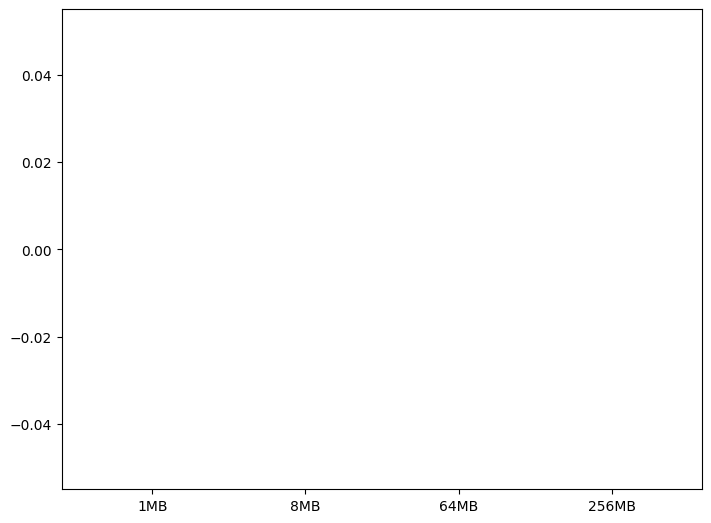

In [29]:
gemmResult = runandPlot(Program.NNPACK_GEMM,yolo ,chaceOptions, chaceSizes, setupnppticks_npp)

reading data from file:  ./bench/build-X86-gem5-opt/NAN/GEMM/256MB/stats.txt 
 
reading data from file:  ./bench/build-X86-gem5-opt/NAN/GEMM/64MB/stats.txt 
 
reading data from file:  ./bench/build-X86-gem5-opt/NAN/GEMM/8MB/stats.txt 
 
reading data from file:  ./bench/build-X86-gem5-opt/NAN/GEMM/1MB/stats.txt 
 
[0, 0, 0, 0]
['256MB', '64MB', '8MB', '1MB']


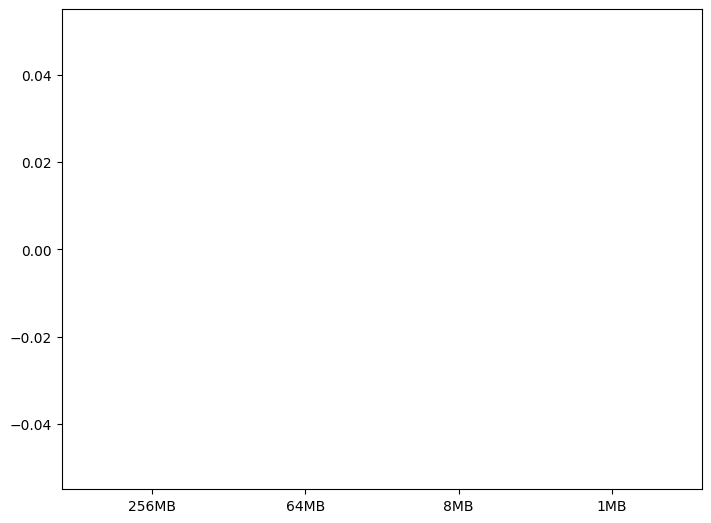

In [30]:
readandplot(gemmResult[0],chaceSizes,setupnppticks_npp)

# WT

rm -rf ./obj/gemm.o ./obj/utils.o ./obj/cuda.o ./obj/deconvolutional_layer.o ./obj/convolutional_layer.o ./obj/list.o ./obj/image.o ./obj/activations.o ./obj/im2col.o ./obj/col2im.o ./obj/blas.o ./obj/crop_layer.o ./obj/dropout_layer.o ./obj/maxpool_layer.o ./obj/softmax_layer.o ./obj/data.o ./obj/matrix.o ./obj/network.o ./obj/connected_layer.o ./obj/cost_layer.o ./obj/parser.o ./obj/option_list.o ./obj/detection_layer.o ./obj/route_layer.o ./obj/upsample_layer.o ./obj/box.o ./obj/normalization_layer.o ./obj/avgpool_layer.o ./obj/layer.o ./obj/local_layer.o ./obj/shortcut_layer.o ./obj/logistic_layer.o ./obj/activation_layer.o ./obj/rnn_layer.o ./obj/gru_layer.o ./obj/crnn_layer.o ./obj/demo.o ./obj/batchnorm_layer.o ./obj/region_layer.o ./obj/reorg_layer.o ./obj/tree.o ./obj/lstm_layer.o ./obj/l2norm_layer.o ./obj/yolo_layer.o ./obj/iseg_layer.o ./obj/image_opencv.o libdarknet.so libdarknet.a darknet ./obj/captcha.o ./obj/lsd.o ./obj/super.o ./obj/art.o ./obj/tag.o ./obj/cifar.o ./ob

./src/convolutional_layer.c: In function ‘forward_convolutional_layer_nnp’:
./src/convolutional_layer.c:549:9: warning: unused variable ‘k’ [-Wunused-variable]
  549 |     int k = l.size*l.size*l.c/l.groups;
      |         ^


gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./src/list.c -o obj/list.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./src/image.c -o obj/image.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./src/activations.c -o obj/activations.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./src/im2col.c -o obj/im2col.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./src/col2im.c -o obj/col2im.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./src/blas.c -o obj/blas.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./src/crop_layer.c -o obj/crop_layer.o
gcc -

gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./examples/classifier.c -o obj/classifier.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./examples/coco.c -o obj/coco.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./examples/yolo.c -o obj/yolo.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./examples/detector.c -o obj/detector.o


./examples/detector.c: In function ‘test_detector’:
./examples/detector.c:585:24: warning: ‘return’ with no value, in function returning non-void [-Wreturn-type]
  585 |             if(!input) return;
      |                        ^~~~~~
./examples/detector.c:562:7: note: declared here
  562 | float test_detector(char *datacfg, char *cfgfile, char *weightfile, char *filename, float thresh, float hier_thresh, char *outfile, int fullscreen)
      |       ^~~~~~~~~~~~~


gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./examples/nightmare.c -o obj/nightmare.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./examples/instance-segmenter.c -o obj/instance-segmenter.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./examples/darknet.c -o obj/darknet.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK -c ./examples/test.c -o obj/test.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -static -Ofast -DNNPACK obj/captcha.o obj/lsd.o obj/super.o obj/art.o obj/tag.o obj/cifar.o obj/go.o obj/rnn.o obj/segmenter.o obj/regressor.o obj/classifier.o obj/coco.o obj/yolo.o obj/detector.o obj/nightmare.o obj/instance-segmenter.o obj/darknet.o obj/test.o libdarknet.a -o darknet -lm -pthread -l:li

warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: failed to generate dot output from ./bench/build-X86-gem5-opt/NAN/WT/256MB/config.dot
build/X86/mem/dram_interface.cc:690: warn: DRAM device capacity (8192 Mbytes) does not match the address range assigned (512 Mbytes)


Global frequency set at 1000000000000 ticks per second


build/X86/base/remote_gdb.cc:416: warn: Sockets disabled, not accepting gdb connections
build/X86/sim/simulate.cc:192: info: Entering event queue @ 0.  Starting simulation...
build/X86/sim/syscall_emul.cc:74: warn: ignoring syscall set_robust_list(...)
build/X86/sim/syscall_emul.cc:74: warn: ignoring syscall rseq(...)
build/X86/sim/mem_state.cc:443: info: Increasing stack size by one page.
build/X86/sim/syscall_emul.cc:74: warn: ignoring syscall mprotect(...)
build/X86/arch/x86/cpuid.cc:180: warn: x86 cpuid family 0x0000: unimplemented function 2
build/X86/sim/mem_state.cc:443: info: Increasing stack size by one page.


gem5 Simulator System.  https://www.gem5.org
gem5 is copyrighted software; use the --copyright option for details.

gem5 version 22.1.0.0
gem5 compiled Jan 24 2023 19:03:31
gem5 started Feb 12 2023 17:00:11
gem5 executing on anton-mint, pid 15830
command line: /home/anton/Master/tools/gem5/gem5-Arm/build/X86/gem5.opt --outdir=./bench/build-X86-gem5-opt/NAN/WT/256MB/ /home/anton/Master/tools/gem5/gem5-Arm/configs/example/se.py --cpu-type=TimingSimpleCPU --cpu-clock=2GHz --l1d_size=64kB --l1i_size=16kB --caches --output=stdout.txt --errout=stderr.txt --l2_size=256MB --l2cache -c ./darknet --options ''

info: Standard input is not a terminal, disabling listeners.
**** REAL SIMULATION ****
Exiting @ tick 177698500 because exiting with last active thread context
/home/anton/Master/tools/gem5/gem5-Arm/build/X86/gem5.opt --outdir=./bench/build-X86-gem5-opt/NAN/WT/64MB/ /home/anton/Master/tools/gem5/gem5-Arm/configs/example/se.py --cpu-type=TimingSimpleCPU --cpu-clock=2GHz --l1d_size=64kB --l1

warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: failed to generate dot output from ./bench/build-X86-gem5-opt/NAN/WT/64MB/config.dot
build/X86/mem/dram_interface.cc:690: warn: DRAM device capacity (8192 Mbytes) does not match the address range assigned (512 Mbytes)


Global frequency set at 1000000000000 ticks per second


build/X86/base/remote_gdb.cc:416: warn: Sockets disabled, not accepting gdb connections
build/X86/sim/simulate.cc:192: info: Entering event queue @ 0.  Starting simulation...
build/X86/sim/syscall_emul.cc:74: warn: ignoring syscall set_robust_list(...)
build/X86/sim/syscall_emul.cc:74: warn: ignoring syscall rseq(...)
build/X86/sim/mem_state.cc:443: info: Increasing stack size by one page.
build/X86/sim/syscall_emul.cc:74: warn: ignoring syscall mprotect(...)
build/X86/arch/x86/cpuid.cc:180: warn: x86 cpuid family 0x0000: unimplemented function 2
build/X86/sim/mem_state.cc:443: info: Increasing stack size by one page.


gem5 Simulator System.  https://www.gem5.org
gem5 is copyrighted software; use the --copyright option for details.

gem5 version 22.1.0.0
gem5 compiled Jan 24 2023 19:03:31
gem5 started Feb 12 2023 17:00:13
gem5 executing on anton-mint, pid 15833
command line: /home/anton/Master/tools/gem5/gem5-Arm/build/X86/gem5.opt --outdir=./bench/build-X86-gem5-opt/NAN/WT/64MB/ /home/anton/Master/tools/gem5/gem5-Arm/configs/example/se.py --cpu-type=TimingSimpleCPU --cpu-clock=2GHz --l1d_size=64kB --l1i_size=16kB --caches --output=stdout.txt --errout=stderr.txt --l2_size=64MB --l2cache -c ./darknet --options ''

info: Standard input is not a terminal, disabling listeners.
**** REAL SIMULATION ****
Exiting @ tick 177698500 because exiting with last active thread context
/home/anton/Master/tools/gem5/gem5-Arm/build/X86/gem5.opt --outdir=./bench/build-X86-gem5-opt/NAN/WT/8MB/ /home/anton/Master/tools/gem5/gem5-Arm/configs/example/se.py --cpu-type=TimingSimpleCPU --cpu-clock=2GHz --l1d_size=64kB --l1i_s

warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: failed to generate dot output from ./bench/build-X86-gem5-opt/NAN/WT/8MB/config.dot
build/X86/mem/dram_interface.cc:690: warn: DRAM device capacity (8192 Mbytes) does not match the address range assigned (512 Mbytes)


Global frequency set at 1000000000000 ticks per second


build/X86/base/remote_gdb.cc:416: warn: Sockets disabled, not accepting gdb connections
build/X86/sim/simulate.cc:192: info: Entering event queue @ 0.  Starting simulation...
build/X86/sim/syscall_emul.cc:74: warn: ignoring syscall set_robust_list(...)
build/X86/sim/syscall_emul.cc:74: warn: ignoring syscall rseq(...)
build/X86/sim/mem_state.cc:443: info: Increasing stack size by one page.
build/X86/sim/syscall_emul.cc:74: warn: ignoring syscall mprotect(...)
build/X86/arch/x86/cpuid.cc:180: warn: x86 cpuid family 0x0000: unimplemented function 2
build/X86/sim/mem_state.cc:443: info: Increasing stack size by one page.


gem5 Simulator System.  https://www.gem5.org
gem5 is copyrighted software; use the --copyright option for details.

gem5 version 22.1.0.0
gem5 compiled Jan 24 2023 19:03:31
gem5 started Feb 12 2023 17:00:14
gem5 executing on anton-mint, pid 15836
command line: /home/anton/Master/tools/gem5/gem5-Arm/build/X86/gem5.opt --outdir=./bench/build-X86-gem5-opt/NAN/WT/8MB/ /home/anton/Master/tools/gem5/gem5-Arm/configs/example/se.py --cpu-type=TimingSimpleCPU --cpu-clock=2GHz --l1d_size=64kB --l1i_size=16kB --caches --output=stdout.txt --errout=stderr.txt --l2_size=8MB --l2cache -c ./darknet --options ''

info: Standard input is not a terminal, disabling listeners.
**** REAL SIMULATION ****
Exiting @ tick 177698500 because exiting with last active thread context
/home/anton/Master/tools/gem5/gem5-Arm/build/X86/gem5.opt --outdir=./bench/build-X86-gem5-opt/NAN/WT/1MB/ /home/anton/Master/tools/gem5/gem5-Arm/configs/example/se.py --cpu-type=TimingSimpleCPU --cpu-clock=2GHz --l1d_size=64kB --l1i_siz

warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: The `get_runtime_isa` function is deprecated. Please migrate away from using this function.
warn: failed to generate dot output from ./bench/build-X86-gem5-opt/NAN/WT/1MB/config.dot
build/X86/mem/dram_interface.cc:690: warn: DRAM device capacity (8192 Mbytes) does not match the address range assigned (512 Mbytes)
build/X86/base/remote_gdb.cc:416: warn: Sockets disabled, not accepting gdb connections


Global frequency set at 1000000000000 ticks per second
gem5 Simulator System.  https://www.gem5.org
gem5 is copyrighted software; use the --copyright option for details.

gem5 version 22.1.0.0
gem5 compiled Jan 24 2023 19:03:31
gem5 started Feb 12 2023 17:00:15
gem5 executing on anton-mint, pid 15839
command line: /home/anton/Master/tools/gem5/gem5-Arm/build/X86/gem5.opt --outdir=./bench/build-X86-gem5-opt/NAN/WT/1MB/ /home/anton/Master/tools/gem5/gem5-Arm/configs/example/se.py --cpu-type=TimingSimpleCPU --cpu-clock=2GHz --l1d_size=64kB --l1i_size=16kB --caches --output=stdout.txt --errout=stderr.txt --l2_size=1MB --l2cache -c ./darknet --options ''

info: Standard input is not a terminal, disabling listeners.
**** REAL SIMULATION ****


build/X86/sim/simulate.cc:192: info: Entering event queue @ 0.  Starting simulation...
build/X86/sim/syscall_emul.cc:74: warn: ignoring syscall set_robust_list(...)
build/X86/sim/syscall_emul.cc:74: warn: ignoring syscall rseq(...)
build/X86/sim/mem_state.cc:443: info: Increasing stack size by one page.
build/X86/sim/syscall_emul.cc:74: warn: ignoring syscall mprotect(...)
build/X86/arch/x86/cpuid.cc:180: warn: x86 cpuid family 0x0000: unimplemented function 2
build/X86/sim/mem_state.cc:443: info: Increasing stack size by one page.


Exiting @ tick 177698500 because exiting with last active thread context
['./bench/build-X86-gem5-opt/NAN/WT/256MB/', './bench/build-X86-gem5-opt/NAN/WT/64MB/', './bench/build-X86-gem5-opt/NAN/WT/8MB/', './bench/build-X86-gem5-opt/NAN/WT/1MB/']
reading data from file:  ./bench/build-X86-gem5-opt/NAN/WT/256MB/stats.txt 
 
reading data from file:  ./bench/build-X86-gem5-opt/NAN/WT/64MB/stats.txt 
 
reading data from file:  ./bench/build-X86-gem5-opt/NAN/WT/8MB/stats.txt 
 
reading data from file:  ./bench/build-X86-gem5-opt/NAN/WT/1MB/stats.txt 
 
[[('simTicks', 177698500)], [('simTicks', 177698500)], [('simTicks', 177698500)], [('simTicks', 177698500)]]
[0, 0, 0, 0]
['1MB', '8MB', '64MB', '256MB']


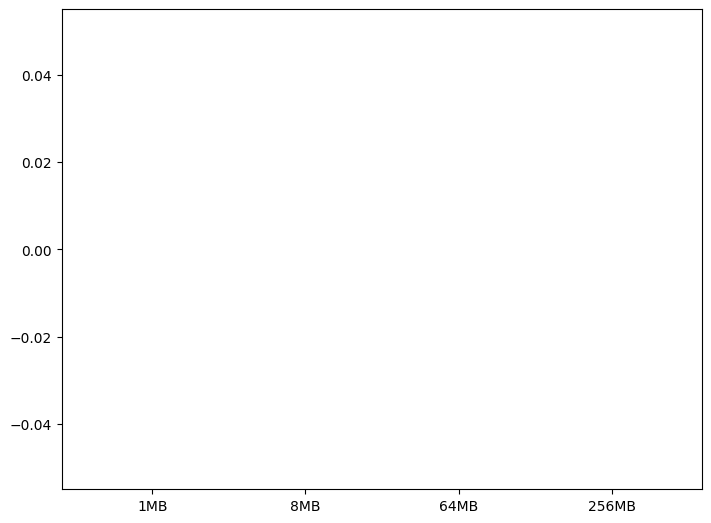

In [31]:
wtResult = runandPlot(Program.NNPACK_WT,yolo ,chaceOptions, chaceSizes, setupnppticks_npp)

reading data from file:  ./bench/build-X86-gem5-opt/NAN/WT/256MB/stats.txt 
 
reading data from file:  ./bench/build-X86-gem5-opt/NAN/WT/64MB/stats.txt 
 
reading data from file:  ./bench/build-X86-gem5-opt/NAN/WT/8MB/stats.txt 
 
reading data from file:  ./bench/build-X86-gem5-opt/NAN/WT/1MB/stats.txt 
 
[0, 0, 0, 0]
['256MB', '64MB', '8MB', '1MB']


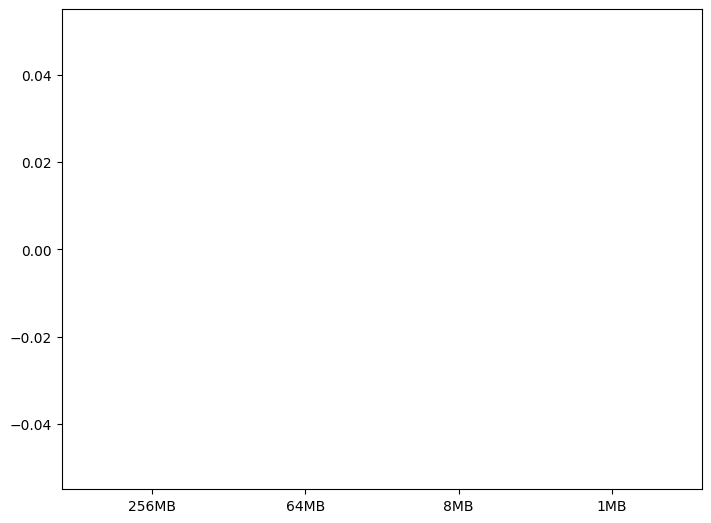

In [32]:
readandplot(wtResult[0],chaceSizes,setupnppticks_npp)